In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
import sys
import matplotlib.image
from numpy import genfromtxt
dtype = tf.float32

In [80]:
#data loading
print("Reading Data..")
data = genfromtxt('shuffledSet.txt')
#set1 = genfromtxt('set1_834450x7.txt')
#set2 = genfromtxt('set2_834450x7.txt')
#ata = np.concatenate((set1,set2),axis=0)
print('loading data finished!')

#reshaping
print("Data restructuring..")
numtrainLogs = 6
trainSize = 3000
testSize = 500

y = data[:,numtrainLogs]
x = data[:,0:numtrainLogs]
yreshape = y.reshape(33543,50, 1)
xreshape = x.reshape(33543,50, numtrainLogs)
xreshape = xreshape.reshape(33543,50*6)
yreshape = yreshape.reshape(33543,50*1)
train_x = xreshape[0:trainSize,:]
train_y = yreshape[0:trainSize,:]
test_x = xreshape[trainSize:trainSize+testSize, :]
test_y = yreshape[trainSize:trainSize+testSize, :]
print('train_x shape: ', train_x.shape)
print('train_y shape: ', train_y.shape)
print('test_x shape: ', test_x.shape)
print('test_y shape: ', test_y.shape)

Reading Data..
loading data finished!
Data restructuring..
train_x shape:  (3000, 300)
train_y shape:  (3000, 50)
test_x shape:  (500, 300)
test_y shape:  (500, 50)


In [81]:
def weight_variable(shape, name):
    #return tf.get_variable(name, shape=shape, dtype=dtype, initializer=tf.contrib.layers.xavier_initializer())
    initial = tf.truncated_normal(shape, stddev=0.1, dtype=tf.float32)
    return tf.Variable(initial, name=name, dtype=tf.float32)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape, dtype=dtype)
    return tf.Variable(initial, name=name, dtype=dtype)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def conv_layer(x, r, c, i, o, name):
    W_conv = weight_variable([r, c, i, o], name + '_w')
    b_conv = bias_variable([o], name + '_b')
    return tf.nn.relu(conv2d(x, W_conv) + b_conv)

def inception_layer(x, i, o11, o21, o22, o31, o32, o41, name):    # input, input_layers, output_layers 1 and 2
    conv5x6 = conv_layer(x, 5, 6, i, o11, name + 'conv5x6')
    conv15x6 = conv_layer(x, 15, 6, i, o21, name + 'conv15x6')
    conv30x6 = conv_layer(x, 30, 6, i, o22, name + 'conv30x6')
    conv50x6 = conv_layer(x, 50, 6, i, o31, name + 'conv50x6')
    return tf.nn.relu(tf.concat([conv5x6, conv15x6, conv30x6], 3))

def max_pool(x, w, h, s):
    return tf.nn.max_pool(x, ksize=[1, w, h, 1],
                          strides=[1, s, s, 1], padding='SAME')

def avg_pool(x, w, h, s):
    return tf.nn.avg_pool(x, ksize=[1, w, h, 1],
                          strides=[1, s, s, 1], padding='SAME')
def avg_pool_final(x, w, h, s):
    return tf.nn.avg_pool(x, ksize=[1, w, h, 1],
                          strides=[1, s, s, 1], padding='VALID')

def fully_connected(X, layers, out, name):
    pre_l = 0
    i = 1
    for l in layers:
        if not pre_l:
            pre_l = l
            continue
        w_h = weight_variable([pre_l, l], name + '_' + str(i) + '_w')
        b_h = bias_variable([l], name + '_' + str(i) + '_b')
        X = tf.nn.relu(tf.matmul(X, w_h) + b_h)
        pre_l = l
        i += 1
    w_h = weight_variable([pre_l, out], name + '_' + str(i) + '_w')
    b_h = bias_variable([out], name + '_' + str(i) + '_b')
    return tf.matmul(X, w_h) + b_h

In [84]:
#initialization
print("Initializing variables..")
BATCH_SIZE = 128
learning_rate = 1.00e-4
epoch = 0 
epochNum = 5
data_size = len(train_x)
lossTrain = np.zeros((epochNum,1))
lossTest = np.zeros((epochNum,1))
    
#Model creation: placeholders
print("Creating Model...")
X = tf.placeholder(dtype, [None, 300])
Y = tf.placeholder(dtype, [None, 50])
tr = tf.placeholder(dtype)
pr = tf.placeholder(dtype)
    
#convolution
x_ = tf.reshape(X, [-1, 50, 6, 1])     # 50 x 6 x 1
print("x_", x_)
conv = inception_layer(x_, 1, 32, 64, 32, 32, 32, 32, 'inc1')  # 50 x 6 x 128
print("inc1", conv)
conv = inception_layer(conv, 128, 64, 32, 32, 32, 32, 32, 'inc2')  # 50 x 6 x 128
print("inc2", conv)
pool = max_pool(conv, 7, 5, 2)             # 50 x 6 x 128
print("pool", pool)
norm = tf.contrib.layers.batch_norm(pool)
print("norm", norm)
conv = inception_layer(norm, 128, 64, 32, 32, 32, 64, 64, 'inc3')  # 25 x 3 x 128
print("inc3", conv)
pool = avg_pool_final(conv, 25, 3, 1)             # 1 x 1 x 128
print("pool", pool)

#FCL and dropout
cnn = tf.reshape(pool, [-1, 128])     # 128
print("cnn", cnn)
cnn = tf.nn.dropout(cnn, pr)
print("cnn dropout", cnn)
out_y = fully_connected(cnn, [128], 50, 'fc1')   # 50
print("yhat", out_y)
print("y", Y.shape)

#loss function
loss = tf.reduce_mean(tf.losses.mean_squared_error(predictions = out_y, labels = Y)) 

#training 
train_step = tf.train.AdamOptimizer(tr).minimize(loss)

Initializing variables..
Creating Model...
x_ Tensor("Reshape_62:0", shape=(?, 50, 6, 1), dtype=float32)
inc1 Tensor("Relu_388:0", shape=(?, 50, 6, 128), dtype=float32)
inc2 Tensor("Relu_393:0", shape=(?, 50, 6, 128), dtype=float32)
pool Tensor("MaxPool_26:0", shape=(?, 25, 3, 128), dtype=float32)
norm Tensor("BatchNorm_24/FusedBatchNorm:0", shape=(?, 25, 3, 128), dtype=float32)
inc3 Tensor("Relu_398:0", shape=(?, 25, 3, 128), dtype=float32)
pool Tensor("AvgPool_29:0", shape=(?, 1, 1, 128), dtype=float32)
cnn Tensor("Reshape_63:0", shape=(?, 128), dtype=float32)
cnn dropout Tensor("dropout_21/mul:0", shape=(?, 128), dtype=float32)
yhat Tensor("add_344:0", shape=(?, 50), dtype=float32)
y (?, 50)


In [85]:
#load trained model
#with tf.Session() as sess:
#    tf.train.Saver().restore(sess, "./model/testmodel.ckpt")
#    lossTrain = sess.run(loss, feed_dict={X: train_x, Y: train_y, pr: 1.0})
#    lossTest = sess.run(loss, feed_dict={X: test_x, Y: test_y, pr: 1.0})
#    yhat = yhat = sess.run(out_y, feed_dict={X: test_x[1:2,:], pr: 1.0})

In [86]:
#Running the training session
saver = tf.train.Saver()
sess = tf.Session()
with sess.as_default() as sess:
    tf.global_variables_initializer().run()
    print("Training...")
    while epoch < epochNum:
        batchIter = 0; 
        for start in range(0, data_size, BATCH_SIZE):
            batchIter += 1
            end = start + BATCH_SIZE
            sess.run(train_step, feed_dict={X: train_x[start:end], Y: train_y[start:end], tr: learning_rate, pr: 0.45})
            batchPer = 100*batchIter*BATCH_SIZE/data_size
            if round(batchPer) % 25 == 0:
                print('percent of batch: ', batchPer) 
        #print accuracy 
        lossTrain[epoch] = sess.run(loss, feed_dict={X: train_x, Y: train_y, pr: 1.0})
        lossTest[epoch] = sess.run(loss, feed_dict={X: test_x, Y: test_y, pr: 1.0})
        print('epoch: ', epoch+1, ', Train Accuracy: ', lossTrain[epoch],'Test Accuracy:', lossTest[epoch], ', learning_rate: ', learning_rate)
        epoch += 1
    writer = tf.summary.FileWriter("./TestModel")
    writer.add_graph(sess.graph)


Training...
epoch:  0 , Train Accuracy:  [2.67974448] Test Accuracy: [2.80741405] , learning_rate:  0.0001
epoch:  1 , Train Accuracy:  [1.56196558] Test Accuracy: [1.70858252] , learning_rate:  0.0001
epoch:  2 , Train Accuracy:  [1.24070454] Test Accuracy: [1.39041245] , learning_rate:  0.0001
epoch:  3 , Train Accuracy:  [1.10680985] Test Accuracy: [1.24486434] , learning_rate:  0.0001
epoch:  4 , Train Accuracy:  [1.04225636] Test Accuracy: [1.17220747] , learning_rate:  0.0001


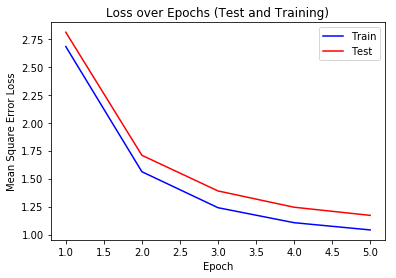

In [87]:
#plotting the loss over epoch
plt.title('Loss over Epochs (Test and Training)')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error Loss')
epochArray = np.array(list(range(1, epochNum+1)))    
plt.plot(epochArray, lossTrain, 'b')
plt.plot(epochArray, lossTest, 'r')
plt.legend(('Train', 'Test'))
plt.show()

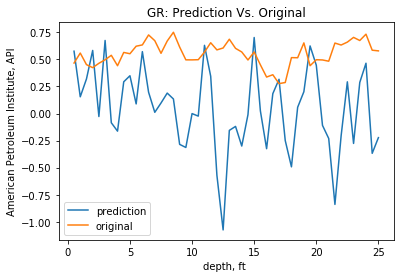

In [88]:
#plotting prediction vs. label Gamma Ray
depthUnit = 0.5    #each data point is half a foot
depthPoint = np.array(list(range(1, 51)))*depthUnit    
yhat = np.transpose(sess.run(out_y, feed_dict={X: test_x[1:2,:], pr: 1.0}))
y = np.transpose(train_y[0:1,:])
plt.plot(depthPoint, yhat)
plt.plot(depthPoint, y)
plt.title('GR: Prediction Vs. Original')
plt.xlabel('depth, ft ')
plt.ylabel('American Petroleum Institute, API')
plt.legend(('prediction', 'original'))
plt.show()

In [74]:
yhat.shape

(1, 50)

In [ ]:
save_path = saver.save(sess, "./model/testmodel.ckpt")

In [ ]:
sess.close()